In [1]:
import mne
import os
import numpy as np

In [3]:
import pandas as pd

data_path = "data/emotiv/EP1.01.txt"

df_emotiv = pd.read_csv(data_path, sep='\t', header=None)



In [4]:
df_emotiv.columns = ['id', 'event', 'device', 'channel', 'code', 'size', 'data']
df_emotiv['data'] = df_emotiv['data'].apply(lambda x: list(map(float, x.split(','))))
df_emotiv.head()

,id,event,device,channel,code,size,data
0,67635,67635,EP,AF3,6,260,"[4395.384615, 4382.564102, 4377.435897, 4387.1..."
1,67636,67635,EP,F7,6,260,"[4489.230769, 4475.384615, 4474.358974, 4486.6..."
2,67637,67635,EP,F3,6,260,"[4538.461538, 4528.717948, 4524.615384, 4526.1..."
3,67638,67635,EP,FC5,6,260,"[4207.692307, 4205.641025, 4200.51282, 4194.35..."
4,67639,67635,EP,T7,6,260,"[4497.948717, 4498.461538, 4494.871794, 4497.9..."


In [5]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, lfilter

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    # y = filtfilt(b, a, data)
    return y

In [6]:
# bandpass filter for each row's data column (which is a list of floats)
lowcut = 0.5
highcut = 30
fs = 128

df_emotiv_copy = df_emotiv.copy()

df_emotiv_copy['data'] = df_emotiv['data'].apply(lambda x: bandpass_filter(x, lowcut, highcut, fs))


In [7]:
df_emotiv_copy["size"].unique()
# get smallest size
min_size = df_emotiv_copy["size"].min()
# shorten all data columns to min_size
df_emotiv_copy['data'] = df_emotiv_copy['data'].apply(lambda x: x[:min_size])

In [8]:
# print all length of data columns
df_emotiv_copy['data'].apply(len).unique()


array([136])

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft

def compute_stft_for_segment(segment, fs, n_fft=256, hop_length=128):
    """
    Compute STFT for a multi-channel EEG segment.
    Args:
        segment: 2D array of shape (256, 14), where rows are time points and columns are channels.
        fs: Sampling frequency in Hz.
        n_fft: Number of FFT points.
        hop_length: Number of overlapping samples between windows.
    Returns:
        stft_results: 3D array of shape (n_channels, n_freq_bins, n_time_frames)
                      containing the magnitude spectrograms for each channel.
    """
    stft_results = []

    # Compute STFT for each channel
    _, _, Zxx = stft(segment, fs, nperseg=n_fft, noverlap=hop_length)
    stft_results.append(np.abs(Zxx))  # Use magnitude spectrogram
    
    return np.array(stft_results)  # Shape: (n_channels, n_freq_bins, n_time_frames)


In [10]:
df_emotiv_copy["data"]

0         [319.95956051800994, 1666.1927774765552, 3682....
1         [326.79103872077593, 1701.7130372662098, 3761....
2         [330.3747649684057, 1720.6844263083037, 3803.7...
3         [306.296604112478, 1595.786876110437, 3529.054...
4         [327.4256568611725, 1706.064922511325, 3773.66...
                                ...                        
910471    [329.62815534864836, 1717.354228389748, 3798.2...
910472    [307.97647579332926, 1604.502394987476, 3549.2...
910473    [333.1372206343024, 1735.7872799909135, 3839.9...
910474    [287.4820413306202, 1497.754963935756, 3312.54...
910475    [285.72750868779315, 1488.575768579764, 3292.8...
Name: data, Length: 910476, dtype: object

In [11]:
# change data column to stft results
n_fft  = min_size // 2
hop_length = n_fft // 2

df_emotiv_copy['stft'] = df_emotiv_copy['data'].apply(lambda x: compute_stft_for_segment(np.array(x), fs, n_fft, hop_length))


In [12]:
# normalize stft results by max - min
df_emotiv_copy['stft'] = df_emotiv_copy['stft'].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))

In [13]:
df_emotiv_copy['stft'][0].shape

(1, 35, 5)

In [14]:
# flatten stft results
df_emotiv_copy['stft_flattened'] = df_emotiv_copy['stft'].apply(lambda x: x.flatten())
df_emotiv_copy['stft_flattened'][0].shape

(175,)

In [15]:
X = np.array(df_emotiv_copy['stft_flattened'].tolist())
y = df_emotiv_copy['event'].values
print(X.shape, y.shape)

(910476, 175) (910476,)


In [16]:
from sklearn.model_selection import train_test_split

print("X shape:", X.shape)
print("y shape:", y.shape)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

X shape: (910476, 175)
y shape: (910476,)
Training set shape: (637333, 175)
Validation set shape: (136571, 175)
Test set shape: (136572, 175)


In [ ]:
# create a random forest model
from sklearn.ensemble import RandomForestClassifier

# Create a random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Evaluate the classifier
train_score = rf.score(X_train.reshape(X_train.shape[0], -1), y_train)
val_score = rf.score(X_val.reshape(X_val.shape[0], -1), y_val)
test_score = rf.score(X_test.reshape(X_test.shape[0], -1), y_test)

print(f"Train accuracy: {train_score:.4f}")
print(f"Validation accuracy: {val_score:.4f}")
print(f"Test accuracy: {test_score:.4f}")

# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# Predict labels for the test set
y_pred = rf.predict(X_test.reshape(X_test.shape[0], -1))

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

labels = np.unique(y)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()



In [ ]:
# save the rf stft model
import joblib

# Save the model
joblib.dump(rf, "rf_stft_model.joblib")

In [ ]:
train = {}

lowcut = 0.5
highcut = 30
fs = 128

for key in dfs.keys():
    train[key] = []
    print(key)
    min = np.inf
    max = -np.inf
    for df in dfs[key]:
        # split the data by 256 samples
        for i in range(0, len(df), 256):
            if i + 256 < len(df):
                data = df[i:i+256][eeg_columns].values
                # apply bandpass filter
                data = bandpass_filter(data, lowcut, highcut, fs)
                extracted = compute_stft_for_segment(data, fs)
                if extracted.min() < min:
                    min = extracted.min()
                if extracted.max() > max:
                    max = extracted.max()
                train[key].append(extracted)
    # normalize the data for consistency
    train[key] = (train[key] - min) / (max - min)
    # change to cnn input
    train[key] = np.array(train[key])
    num_samples, num_channels, height, width = train[key].shape
    # train[key] = train[key].reshape(num_samples, num_channels, height, width)
    # merge the 14 channels in to one picture

# save min and max values
np.save("min_stft.npy", min)
np.save("max_stft.npy", max)

9
0
7
6
1
8
4
3
2
5


In [ ]:
train["0"].shape # we treat them as image

(23, 14, 129, 3)

In [8]:
import pandas as pd

# Combine data from the dictionary
X = []
y = []
labels = []

for label, data in train.items():
    X.append(data)  # Add all the spectrograms
    y.extend([label] * data.shape[0])  # Extend labels for each sample
    # create a mapping of the labels
    labels.append(label)
    
# use categorical encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)

# Convert to numpy arrays
X = np.concatenate(X, axis=0)
y = np.array(y)
# change y to categorical
y = le.transform(y)

print(y)
# labels count
print(len(le.classes_))

outputs = len(le.classes_)

[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
10


In [9]:
y

array([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5])

In [10]:
X.shape

(199, 14, 129, 3)

In [12]:
from sklearn.model_selection import train_test_split

print("X shape:", X.shape)
print("y shape:", y.shape)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

X shape: (199, 14, 129, 3)
y shape: (199,)
Training set shape: (139, 14, 129, 3)
Validation set shape: (30, 14, 129, 3)
Test set shape: (30, 14, 129, 3)


Train accuracy: 1.0000
Validation accuracy: 0.5000
Test accuracy: 0.6667


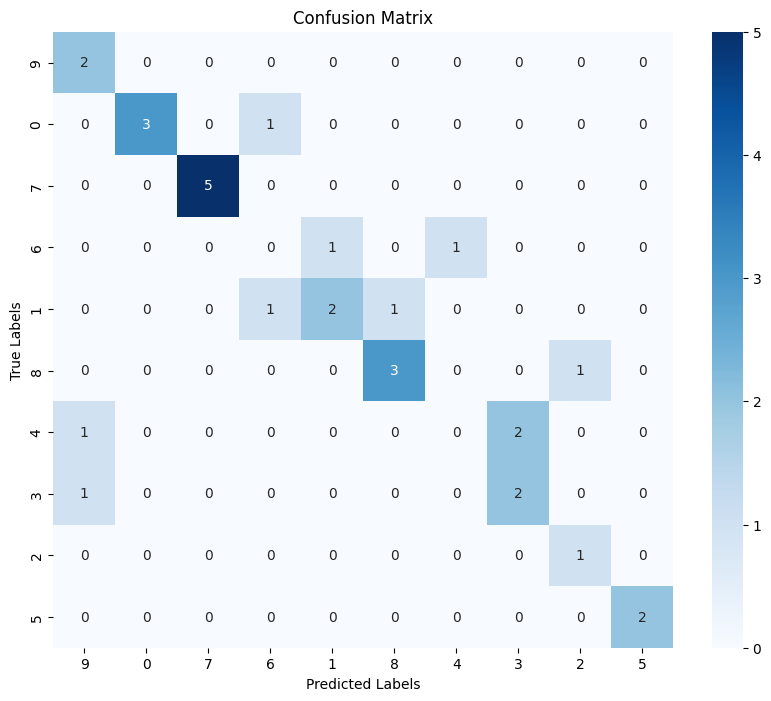

In [14]:
# create a random forest model
from sklearn.ensemble import RandomForestClassifier

# Create a random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Evaluate the classifier
train_score = rf.score(X_train.reshape(X_train.shape[0], -1), y_train)
val_score = rf.score(X_val.reshape(X_val.shape[0], -1), y_val)
test_score = rf.score(X_test.reshape(X_test.shape[0], -1), y_test)

print(f"Train accuracy: {train_score:.4f}")
print(f"Validation accuracy: {val_score:.4f}")
print(f"Test accuracy: {test_score:.4f}")

# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# Predict labels for the test set
y_pred = rf.predict(X_test.reshape(X_test.shape[0], -1))

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()



In [77]:
import torch
from torch.utils.data import Dataset, DataLoader

class EEGDataset(Dataset):
    def __init__(self, data, labels):
        """
        Args:
            data: A NumPy array of shape (num_samples, channels, height, width).
            labels: A NumPy array of shape (num_samples,) with classification labels.
        """
        self.data = torch.tensor(data, dtype=torch.float32)  # Convert data to tensor
        self.labels = torch.tensor(labels, dtype=torch.long)  # Convert labels to tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]  # Shape: (channels, height, width)
        y = self.labels[idx]  # Shape: ()
        return x, y

# Create PyTorch Datasets
train_dataset = EEGDataset(X_train, y_train)
val_dataset = EEGDataset(X_val, y_val)
test_dataset = EEGDataset(X_test, y_test)


In [78]:
import torch.nn as nn
import torch.nn.functional as F

class EEGCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(EEGCNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, stride=1, padding=(1, 1))  # Conv1
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 1))  # Pool only height

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=(1, 1))  # Conv2
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 1))  # Pool only height

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=(1, 1))  # Conv3
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 1))  # Pool only height

        # Calculate flattened size
        self.fc1 = nn.Linear(64 * (129 // 8) * 3, 128)  # Adjust for reduced height and fixed width
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define model
input_channels = X_train.shape[1]  # Number of channels in the input data
num_classes = len(le.classes_)  # Number of classes
model = EEGCNN(input_channels, num_classes)
print(model)

EEGCNN(
  (conv1): Conv2d(14, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [79]:
import torch.optim as optim

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        val_loss, val_acc = validate_model(model, val_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Validation function
def validate_model(model, val_loader):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return val_loss / len(val_loader), correct / total

# Train the model
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {correct / total:.4f}")

In [80]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

train_model(model, train_loader, val_loader, num_epochs=10)
test_model(model, test_loader)

Epoch 1/10, Loss: 11.4874, Val Loss: 2.3276, Val Acc: 0.1000
Epoch 2/10, Loss: 11.4958, Val Loss: 2.3644, Val Acc: 0.0667
Epoch 3/10, Loss: 11.4278, Val Loss: 2.3736, Val Acc: 0.0667
Epoch 4/10, Loss: 11.4276, Val Loss: 2.3821, Val Acc: 0.0667
Epoch 5/10, Loss: 11.4344, Val Loss: 2.3720, Val Acc: 0.0667
Epoch 6/10, Loss: 11.3780, Val Loss: 2.3673, Val Acc: 0.0667
Epoch 7/10, Loss: 11.4234, Val Loss: 2.3676, Val Acc: 0.0667
Epoch 8/10, Loss: 11.3601, Val Loss: 2.3749, Val Acc: 0.0667
Epoch 9/10, Loss: 11.4704, Val Loss: 2.3949, Val Acc: 0.0667
Epoch 10/10, Loss: 11.4208, Val Loss: 2.3805, Val Acc: 0.0667
Test Accuracy: 0.0667


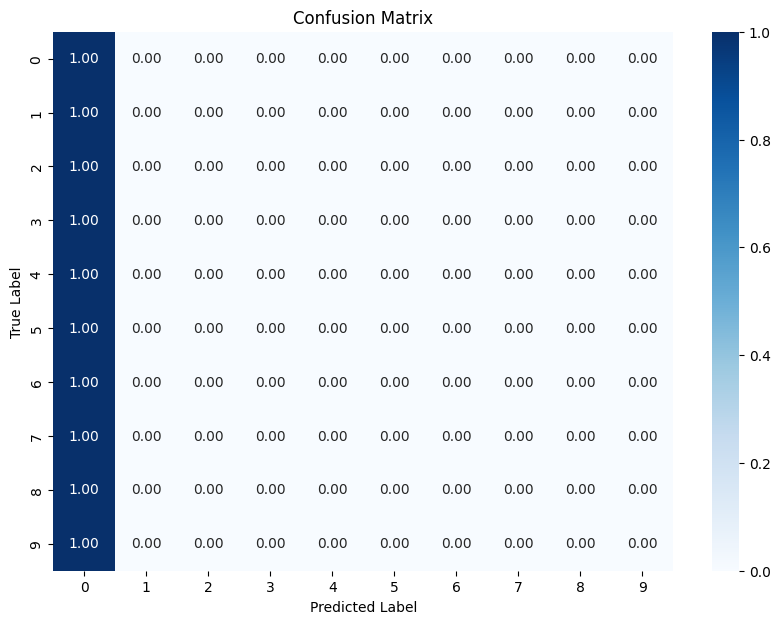

In [81]:
# draw confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm / cm.sum(axis=1)[:, np.newaxis]  # Normalize
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=True, cmap="Blues", fmt=".2f")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Get predictions
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, le.classes_)